In [25]:
!pip install wordcloud

     |████████████████████████████████| 220 kB 2.7 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158478 sha256=aab320b1b573bc457c7de2c7d9e259bb74b74cb3b18fd45f6511dd72df9a2ec9
  Stored in directory: /Users/vaishakkallampad/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud


In [28]:
conda install -c conda-forge wordcloud=1.8.1

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/vaishakkallampad/opt/anaconda3/envs/tensorflow

  added / updated specs:
    - wordcloud=1.8.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.5.18  |       h033912b_0         144 KB  conda-forge
    certifi-2022.5.18          |   py38h50d1736_0         150 KB  conda-forge
    openssl-1.1.1o             |       hfe4f2af_0         1.9 MB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    wordcloud-1.8.1            |   py38h96a0964_2         171 KB  conda-forge
    ------------------------------------------------------------
                                           

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
from nltk.tokenize import sent_tokenize
from wordcloud import WordCloud
from prettytable import PrettyTable

In [2]:
class TedTalk:
    def __init__(self):
        self.speaker_data = pd.read_csv('dataset/speaker_data.csv')
        self.talk_data = pd.read_csv('dataset/talk_data.csv')
        self.transcript_data = pd.read_csv('dataset/transcript_data.csv')
        self.preprocessed_data = self.preprocessing()
        self.themes_df = pd.DataFrame()
#         self.recommendation_df = self.recommendations()
        
    def preprocessing(self):
        # filling 648 'speaker_occ'=Nan with value 'Unknown'
        self.speaker_data['speaker_occ'] = self.speaker_data['speaker_occ'].fillna('Unknown')
        #filling 623 'speaker_bio'=Nan with value 'Unknown'
        self.speaker_data['speaker_bio'] = self.speaker_data['speaker_bio'].fillna('Unknown')
        
        self.speaker_data['speaker'] = self.speaker_data['speaker'].fillna('Unknown')
        #dropping the 'speaker_title' since majority is Nan and it does not provide any useful insight for our use case
        self.speaker_data = self.speaker_data.drop(columns=['speaker_title'])
        
        self.transcript_data = self.transcript_data.dropna(subset=['transcript'])
        
        final_df = pd.merge(self.speaker_data, self.talk_data, how='inner', left_on = 'talk', right_on = 'talk_name')
        #Dropping the duplicate column 'talk_name'
        final_df = final_df.drop(columns=['talk_name'])
        final_df = pd.merge(final_df, self.transcript_data, how='inner', left_on = 'talk', right_on = 'title')
        
        final_df = final_df.drop(columns=['title'])
        #Removing all rows which have duplicated talk name
        final_df = final_df.drop_duplicates(subset=['talk'])
        final_df = final_df.reset_index()
        
        Text=final_df['transcript'].tolist()
        tfidf=text.TfidfVectorizer(input=Text,stop_words="english")
        matrix=tfidf.fit_transform(Text)
        sim_unigram=cosine_similarity(matrix)
        def get_similar_articles(x):
            return "-,".join((final_df['talk']).loc[x.argsort()[-6:-1]])
        final_df['most_similar_transcript_unigrams']=[get_similar_articles(x) for x in sim_unigram]
#         final_df.to_csv('clean_data.csv',index=False)
        return final_df
    
    def statistics(self):
        print("\nHere are few interesting insights for you")
        self.videos_per_year_graph()
        print()
        self.get_pop_theme_graph()
        print()
        self.top_speaker()
        print()
        self.most_famous_talks()
        print()
        self.top_events()
        print()
        
        
    def videos_per_year_graph(self):
        df = self.preprocessed_data.copy(deep=True)
        # convert the recorded_at  Date to datetime
        df['recorded_at'] = pd.to_datetime(df['recorded_at'])
        # add a column for Year
        df['Year'] = df['recorded_at'].dt.year
        # print the dataframe
        df['year'] = pd.to_datetime(df['recorded_at']).dt.year
        
        fig = plt.figure() 
        fig.set_size_inches(8,6)
        df.Year.value_counts().sort_index().plot()
        plt.title("Rise in Videos Over the Years")
        plt.xlabel('Years')
        plt.ylabel('Number of Videos Released per year')
        plt.show()
        return
    
    def most_famous_talks(self):
        print("These are our top 25 videos:")
        famous_talks = self.preprocessed_data.sort_values('views', ascending=False)[:25]
        display(famous_talks.iloc[:,[1,2,5,6,7]])
        return
    
    def get_themes(self):
        df = self.preprocessed_data.copy(deep=True)
        df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))
        s = df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
        s.name = 'theme'
        self.themes_df = df.join(s)
        pop_themes = pd.DataFrame(self.themes_df['theme'].value_counts()).reset_index()
        pop_themes.columns = ['theme', 'talks']
        top_10 = pop_themes[~((pop_themes['theme']=='TED-Ed') | (pop_themes['theme']=='TEDx'))].iloc[0:10,:]
        top_10 = top_10.reset_index(drop=True)
        return top_10
    
    def get_pop_theme_list(self):
        top_10 = self.get_themes()
        print('\nHere are few popular talk themes:')
        for i in range(len(top_10['theme'])):
            print('\n\t',i+1,top_10['theme'][i])
        return
    
    def get_pop_theme_graph(self):
        top_10 = self.get_themes()
        plt.figure(figsize=(15,5))
        sns.barplot(x='theme', y='talks', data=top_10.head(10))
        plt.title("Most popular themes over the years")
        plt.xlabel('Themes')
        plt.ylabel('Number of talks')
        plt.show()
        return
        
        
    def get_top_100_talk_theme(self,theme):
        print('\nHere are the top 50 talk on ',theme)
        top100 = self.themes_df[self.themes_df['theme']==theme].sort_values('views', ascending=False)[:50]
        display(top100.iloc[:,[1,2,6,7]])
        return top100.iloc[:,[1,2,6,7]]
    
    
    def top_speaker(self):
        df = self.preprocessed_data.copy(deep=True)
        df['speaker_frequency'] = df.groupby('speaker')['speaker'].transform('count')
        df['speaker_views'] = df.groupby('speaker')['views'].transform('sum')
        df['speaker_avg_views'] =  df["speaker_views"]/df["speaker_frequency"]
        df = df.sort_values('speaker_avg_views',ascending=[False])
        plt.figure(figsize=(15,5))
        sns.barplot(x='speaker', y='speaker_avg_views', data=df.head(20))
        plt.title("Most Popular Speakers")
        plt.xticks(rotation=90)
        plt.xlabel('Popular Speakers')
        plt.ylabel('Average Views')
        plt.show()
        
    def top_events(self):
        df = self.preprocessed_data.copy(deep=True)
        df['event_frequency'] = df.groupby('event')['event'].transform('count')
        df['event_views'] = df.groupby('event')['views'].transform('sum')
        df['event_avg_views'] =  df["event_views"]/df["event_frequency"]
        df = df.sort_values('event_avg_views',ascending=[False])
        plt.figure(figsize=(15,5))
        sns.barplot(x='event', y='event_avg_views', data=df.head(20))
        plt.title("Most Popular Ted Events")
        plt.xticks(rotation=90)
        plt.xlabel('Events')
        plt.ylabel('Number of Shows')
        plt.show()
        return
    
    def talk_details(self,talk_id):
#         display(self.preprocessed_data.head(1))
#         print(self.preprocessed_data['index'talk_id])
#         display(self.preprocessed_data[self.preprocessed_data['index']==talk_id])
        if talk_id not in self.preprocessed_data.index:
            print("Wrong number selected. Please try again")
            return
        else:
            print('\n\033[1mTalk\033[0m : ',self.preprocessed_data['talk'][talk_id])
            print('\033[1mSpeaker\033[0m : ',self.preprocessed_data['speaker'][talk_id])
            print('\033[1mSpeaker Occupation\033[0m : ',self.preprocessed_data['speaker_occ'][talk_id])
            print('\033[1mTalk Description\033[0m : ',self.preprocessed_data['talk_desc'][talk_id])
            print('\033[1mEvent\033[0m : ',self.preprocessed_data['event'][talk_id])
            print('\033[1mViews\033[0m : ',self.preprocessed_data['views'][talk_id])
            print('\033[1mTags\033[0m : ',self.preprocessed_data['tags'][talk_id])
            print('\n\n',self.generate_wordcloud(talk_id))
            print("\n\033[1mTranscript\033[0m: \n",self.preprocessed_data['transcript'][talk_id])
            print('\n\n',self.get_similar5(talk_id))
            return
            
            
            
            
#     def recommendations(self):
#         cleaned_df = pd.read_csv('clean_data.csv')
#         Text=cleaned_df['transcript'].tolist()
#         tfidf=text.TfidfVectorizer(input=Text,stop_words="english")
#         matrix=tfidf.fit_transform(Text)
#         sim_unigram=cosine_similarity(matrix)
#         def get_similar_articles(x):
#             return ",".join((cleaned_df['talk']).loc[x.argsort()[-6:-1]])
#         cleaned_df['most_similar_transcript_unigrams']=[get_similar_articles(x) for x in sim_unigram]
#         return cleaned_df
    
    def get_similar5(self,talk_index):
        rec_df = self.preprocessed_data.copy(deep=True)
        example_talk = rec_df.iloc[talk_index,1]
        example_tags = rec_df.iloc[talk_index,9]
        example_recommendations_unigram = rec_df.iloc[talk_index,13].split('-,')
        listA = [''.join(c for c in word if c.isalpha()) for word in example_tags.split(',')]
        setA = set(listA)
        print("Recommendations Unigram : ")
        myTable = PrettyTable(["Talk Id.","Recommended Talks(B)", "(tagsA & tagsB)/tagsA", "(tagsA & tagsB)/tagsB"])
        for each in example_recommendations_unigram[::-1]:
            tagsB = rec_df['tags'][rec_df.talk==each].values
            listB = [''.join(c for c in word if c.isalpha()) for word in tagsB[0].split(',')]
            setB = set(listB)
            overlap = setA & setB
            universe = setA | setB
            result1 = round(float(len(overlap)) / len(setA) * 100,1)
            result2 = round(float(len(overlap)) / len(setB) * 100,1)
            talkid= rec_df[rec_df.talk==each].index.values
            myTable.add_row([talkid,each, result1, result2])
        print(myTable)
        print()
        return
    
    
    
    def generate_wordcloud(self,talk_index):
#         df = self.preprocessed_data.copy(deep=True)
        text = self.preprocessed_data['transcript'][talk_index] 
        wordcloud = WordCloud(collocations = False, background_color = 'white').generate(str(text))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()


    
        
        
        
        

In [3]:
if __name__=="__main__":
    ttrs = TedTalk()



TED TALK App

Lets see if we can keep you enganged
Here are your options:

	1. View overall statistics of the Ted Talks over the years

	2. No stats pls! I want to see some good videos

	3. I want to exit

Enter your choice : 
1

Here are few interesting insights for you


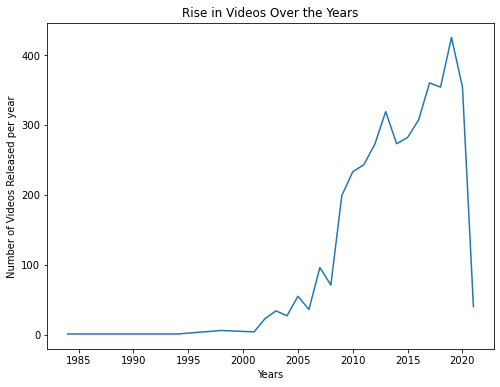

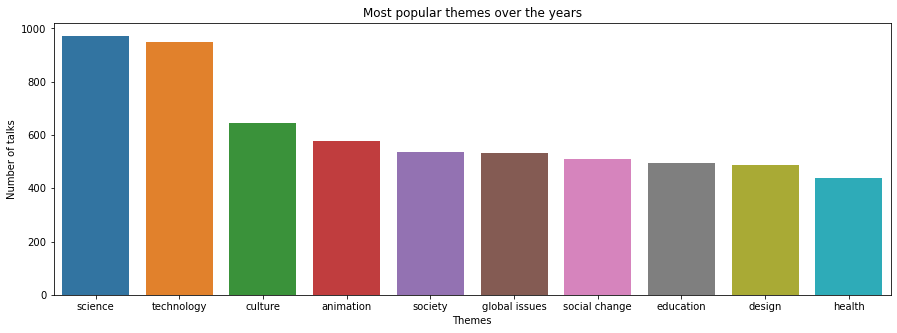

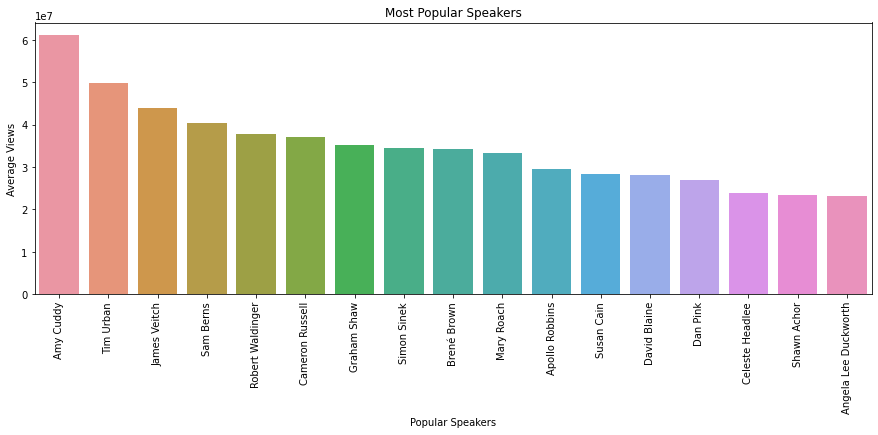


These are our top 25 videos:


,talk,speaker,talk_desc,event,views
4012,Do schools kill creativity?,Sir Ken Robinson,Sir Ken Robinson makes an entertaining and pro...,TED2006,70176973
1959,This is what happens when you reply to spam email,James Veitch,"Suspicious emails: unclaimed insurance bonds, ...",TEDGlobal>Geneva,63683410
2833,Your body language may shape who you are,Amy Cuddy,(NOTE: Some of the findings presented in this ...,TEDGlobal 2012,61030600
3437,How great leaders inspire action,Simon Sinek,Simon Sinek has a simple but powerful model fo...,TEDxPuget Sound,54351663
3299,The power of vulnerability,Brené Brown,Brené Brown studies human connection -- our ab...,TEDxHouston,52871680
1909,Inside the mind of a master procrastinator,Tim Urban,Tim Urban knows that procrastination doesn't m...,TED2016,49876247
2343,How to speak so that people want to listen,Julian Treasure,"Have you ever felt like you're talking, but no...",TEDGlobal 2013,45961304
2147,The next outbreak? We're not ready,Bill Gates,"In 2014, the world avoided a global outbreak o...",TED2015,40591593
1317,My philosophy for a happy life,Sam Berns,Born with a rare genetic disorder called proge...,TEDxMidAtlantic 2013,40315294
1964,What makes a good life? Lessons from the longe...,Robert Waldinger,What keeps us happy and healthy as we go throu...,TEDxBeaconStreet,37902552


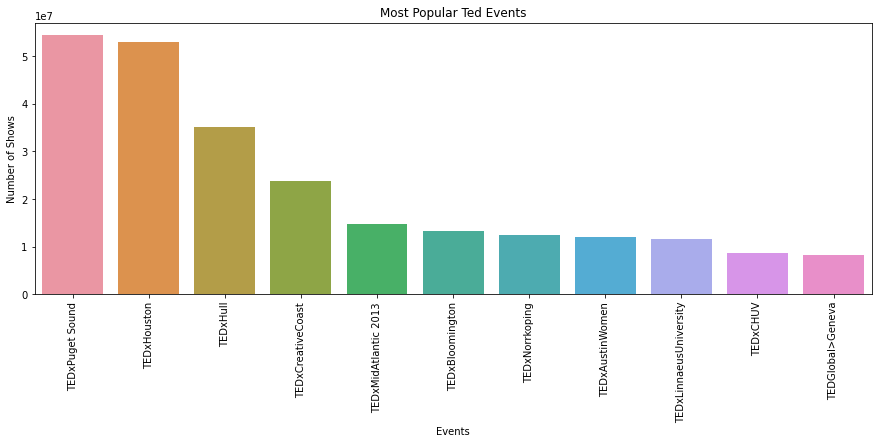



Lets see if we can keep you enganged
Here are your options:

	1. View overall statistics of the Ted Talks over the years

	2. No stats pls! I want to see some good videos

	3. I want to exit

Enter your choice : 
3


In [4]:
print("\n\033[1mTED TALK App\033[0m")
home =True

while home:
    print("\nLets see if we can keep you enganged")
    print("Here are your options:")
    print("\n\t1. View overall statistics of the Ted Talks over the years")
    print("\n\t2. No stats pls! I want to see some good videos")
    print("\n\t3. I want to exit")
    print("\nEnter your choice : ")
    while True:
        try:
            x = int(input())
        except ValueError:
            print("Expecting a valid input")
            continue
        else:
            break
    if x==1:
        ttrs.statistics()
    elif x==2:
        top_10_themes = ttrs.get_themes()
        checktheme = True
        while checktheme:
            ttrs.get_pop_theme_list()
            print("\nWhich one would you like to checkout. Enter number:")
            theme_choice = input()
            sametheme = True
            while sametheme:
                top100_talks_theme = ttrs.get_top_100_talk_theme(top_10_themes['theme'][int(theme_choice)-1])
                print('-->If you want to checkout any of these enter the number you see next the Ted Talk name.', 
                      '\n-->If you want to explore some other theme, enter 9999',
                      '\n-->Go back to home page, enter -1 ')
                talk_choice = int(input())
                if talk_choice==9999:
                    sametheme = False
                    continue
                elif talk_choice==-1:
                    home = True
                    checktheme = False
                    sametheme = False
                    continue
                else :
                    ttrs.talk_details(talk_choice)
                    print('-->If you want to checkout ted talks under the same theme enter 0', 
                          '\n-->Go back to home page, enter -1')
                    y = int(input())
                    if y==-1:
                        sametheme = False
                        checktheme = False
                        continue
    elif x==3:
        home=False
        break
            





In [ ]:
-1
